# LCLS Cu Injector Surrogate Model  (up to OTR2)

predict $\epsilon_x$, $\epsilon_y$, $\sigma_x$, $\sigma_y$, $\sigma_z$
from NN trained on lume-IMPACT-T simulations


# Links to Sections

* [Initial model info](#init)

* [Build model functions](#build)

* [Model predict with simulation units](#predict)

* [Model predict with machine units](#predict_machine)

* [Model comparison with sim scans](#scan)

* [Model comparison with a corrplot](#meas)

* [Bayesian Optimization of Model](#BO)




# Imports

In [1]:
# import tensorflow as tf
# import tensorflow.keras as keras

# from tensorflow.keras.models import Sequential, Model,load_model
# from tensorflow.keras.layers import Input, Dense, Conv1D, Dropout, Activation, GaussianNoise, Reshape,  Conv2D, UpSampling2D
# from tensorflow.keras import regularizers, datasets, layers, models
# from tensorflow.keras.losses import mse 
# from tensorflow.keras.models import load_model
#from sklearn.preprocessing import StandardScaler

import torch
from lume_model.torch import LUMEModule, PyTorchModel
from lume_model.utils import variables_from_yaml
from botorch.models.transforms import Normalize
from botorch.models.transforms.input import AffineInputTransform
from xopt.vocs import VOCS

import numpy as np
import matplotlib.pyplot as plt
import time
import sys, os
import pickle as pick
import pandas as pd
import json
import array
import random
from math import sqrt
import pickle

from IPython.display import clear_output

#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import RobustScaler,MinMaxScaler

import numdifftools as nd

/sdf/group/ard/thakur12/mamba/envs/envs/lume-lcls-cu-inj-nn-tuning/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<a id="init"></a>
# Initial Info

### Loading basic model info
todo - put into config file

In [2]:
PATH = ''
screen ='OTR2'
NAME = 'v3b_cnsga_'

In [3]:
with open(PATH+NAME+screen+'_list_dict.json') as json_file:
    json_names = json.load(json_file)
    
#inputs and outputs in raw data
output_names=json_names['out_'+screen+'_vars']
input_names = json_names['input_vars']


In [4]:
#load model info
model_info = json.load(open('./model_info.json'))

#inputs and outputs model is  trained on
model_in_list = model_info['model_in_list']
model_out_list = model_info['model_out_list']

#dictionary of location of variables in array
loc_in = model_info['loc_in']
loc_out = model_info['loc_out']

#inputs and outputs model is  trained on
input_mins = model_info['train_input_mins']
input_maxs = model_info['train_input_maxs']

In [5]:
model_in_list

['distgen:r_dist:sigma_xy:value',
 'distgen:t_dist:length:value',
 'distgen:total_charge:value',
 'SOL1:solenoid_field_scale',
 'CQ01:b1_gradient',
 'SQ01:b1_gradient',
 'L0A_scale:voltage',
 'L0A_phase:dtheta0_deg',
 'L0B_scale:voltage',
 'L0B_phase:dtheta0_deg']

### Conversion between sim and machine

Explanation on model inputs and how they relate to PVs:
https://github.com/slaclab/lcls-cu-inj-surrogate/blob/master/pv_mapping/cu_inj_impact.csv

In [6]:
pv_info = json.load(open('./pvinfo.json'))

In [7]:
pv_info.keys()

dict_keys(['pv_to_sim_factor', 'pv_unit', 'pv_name_to_sim_name', 'sim_name_to_pv_name', 'sim_to_pv_factor'])

In [8]:
pv_to_sim_factor = pv_info['pv_to_sim_factor']
sim_to_pv_factor = pv_info['sim_to_pv_factor']
pv_unit = pv_info['pv_unit']
pv_name_to_sim_name = pv_info['pv_name_to_sim_name']
sim_name_to_pv_name = pv_info['sim_name_to_pv_name']

In [9]:
## functions to convert between sim and machine units for data
def sim_to_machine(sim_vals, 
                   model_in_list = model_in_list,
                   loc_in = loc_in,
                   pv_to_sim_factor = pv_to_sim_factor,
                   sim_name_to_pv_name = sim_name_to_pv_name):

    pv_vals = np.copy(sim_vals)
    
    for i in range(0,len(model_in_list)):
        pv_vals[:,loc_in[model_in_list[i]]]=np.asarray(sim_vals)[:,loc_in[model_in_list[i]]]/pv_to_sim_factor[sim_name_to_pv_name[model_in_list[i]]]
    
    return pv_vals


def machine_to_sim(pv_vals, 
                   model_in_list = model_in_list,
                   loc_in = loc_in,
                   pv_to_sim_factor = pv_to_sim_factor,
                   sim_name_to_pv_name = sim_name_to_pv_name):

    sim_vals = np.copy(pv_vals)
    
    for i in range(0,len(model_in_list)):
        sim_vals[:,loc_in[model_in_list[i]]] = np.asarray(pv_vals)[:,loc_in[model_in_list[i]]]*pv_to_sim_factor[sim_name_to_pv_name[model_in_list[i]]]
    
    return sim_vals

### class for running surrogate

In [21]:
class Surrogate_NN:
    
    def __init__(self, 
                 model_in_list,
                 model_out_list,
                 input_mins,
                 input_maxs,
                 pv_name_to_sim_name,
                 pv_to_sim_factor,
                 sim_name_to_pv_name,
                 take_log_out= True
                ):
        
        #input variable names
        self.model_in_list = model_in_list
        self.model_out_list = model_out_list
        
        #dictionary mapping names to indices
        self.loc_in = {model_in_list[i]: np.arange(0,len(model_in_list))[i] for i in range(len(model_in_list))} 
        self.loc_out = {model_out_list[i]: np.arange(0,len(model_out_list))[i] for i in range(len(model_out_list))} 
        
        self.input_mins = input_mins
        self.input_maxs = input_maxs
        self.take_log_out = take_log_out
        
        self.debug = False
        
        self.pv_name_to_sim_name = pv_name_to_sim_name
        self.pv_to_sim_factor = pv_to_sim_factor
        self.sim_name_to_pv_name = sim_name_to_pv_name
        
    def pred_sim_units(self, x):
    
            x = self.transformer_x.transform(x)
            y = self.model_1.predict(x)
            y = self.transformer_y.inverse_transform(y)

            if self.take_log_out == True:
                return np.exp(y) #trained on log data
            
            else:
                return y
        
    def pred_machine_units(self, x):

            x_s = np.copy(x)
            
            for i in range(0,len(self.model_in_list)):
                x_s[:,self.loc_in[self.model_in_list[i]]] =  x[:,self.loc_in[self.model_in_list[i]]] * self.pv_to_sim_factor[self.sim_name_to_pv_name[self.model_in_list[i]]]

            if self.debug:
                print('small scale units',x_s)

            #scale for NN pred
            
            x_s =  self.transformer_x.transform(x_s)
            y = self.model_1.predict(x_s)
            y = self.transformer_y.inverse_transform(y)
            
            if self.take_log_out == True:
                return np.exp(y) #trained on log data
            
            else:
                return y

        
    def load_saved_model(self, model_path = './', model_name = 'model_OTR_rms_emit'):
        
            self.model_1 = load_model(model_path + model_name +'.h5')
            self.savepath = model_path +'figures/'
            
    def load_scaling(self,scalerfilex = 'transformer_x.sav', scalerfiley = 'transformer_y.sav'):
        
            
            if scalerfilex[-3:] == 'sav':
            
                self.transformer_x = pickle.load(open(scalerfilex, 'rb'))

                self.transformer_y = pickle.load(open(scalerfiley, 'rb'))
            

In [22]:
def load_scaling(scalerfilex = 'transformer_x.sav', scalerfiley = 'transformer_y.sav'):
    if scalerfilex[-3:] == 'sav':
        transformer_x = pickle.load(open(scalerfilex, 'rb'))
        transformer_y = pickle.load(open(scalerfiley, 'rb'))
    return transformer_x, transformer_y
transformer_x, transformer_y = load_scaling()
# print(transformer_x)

def load_surrogate(variable_file: str, normalizations_file: str,
                   model_file: str, transformers: []) -> PyTorchModel:
    """Loads the LCLS injector NN surrogate model from file.

    Args:
        variable_file: Path to a yaml-file defining the in- and output
          variables of the surrogate model.
        normalizations_file: Path to a json-file defining the normalization
          transformers for the surrogate model.
        model_file: Path to the torch-file defining the NN model.

    Returns:
        The LCLS injector NN surrogate model as a PyTorchModel.
    """
    with open(variable_file) as f:
        input_variables, output_variables = variables_from_yaml(f)

    with open(normalizations_file, 'r') as f:
        norm_data = json.load(f)

    #transformers = [transformer_x, transformer_y]
#     transformers = []
#     for ele in ["x", "y"]:
#         scale = torch.tensor(norm_data[f"{ele}_scale"], dtype=torch.double)
#         min_val = torch.tensor(norm_data[f"{ele}_min"], dtype=torch.double)
#         transform = AffineInputTransform(
#             len(norm_data[f"{ele}_min"]),
#             1 / scale,
#             -min_val / scale,
#         )
#         transformers.append(transform)

    surrogate = PyTorchModel(
        model_file,
        input_variables, output_variables,
        input_transformers=[transformers[0]],
        output_transformers=[transformers[1]],
    )
    return surrogate

def create_vocs(surrogate: PyTorchModel,
                objective_name: str = "negative_sigma_xy") -> VOCS:
    """Creates VOCS object for xopt.

    Args:
        surrogate: The surrogate model.
        objective_name: The name of the objective (only "negative_sigma_xy"
          is supported for now).

    Returns:
        The VOCS object.
    """
    if not objective_name == "negative_sigma_xy":
        raise ValueError(f"objective_name {objective_name} is not supported")
    xopt_variables = {}
    constant_variables = {}
    for input_name, variable in surrogate.input_variables.items():
        if variable.value_range[0] == variable.value_range[1]:
            constant_variables[input_name] = variable.value_range[0]
        else:
            xopt_variables[input_name] = variable.value_range
    vocs = VOCS(
        variables=xopt_variables,
        objectives={objective_name: "MAXIMIZE"},
        constants=constant_variables
    )
    return vocs

/sdf/group/ard/thakur12/mamba/envs/envs/lume-lcls-cu-inj-nn-tuning/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [23]:
def plot_multiple_comparison(scanvar,
                             X_scan,
                             Y_pred,
                             X_data,
                             Y_data,
                             xlabel,
                             min_emit = 5.461418942827289e-07,
                             leg = []):
    
    plt.plot(X_data, Y_data['norm_emit_x']*10**6,'.')    
    plt.plot(X_scan, Y_pred[:,loc_out['norm_emit_x']]*10**6,'.')
    plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
    plt.xlabel(xlabel)
    plt.legend(leg)
    plt.ylim([min_emit*10**6,1])
    plt.show()
    
    plt.plot(X_data, Y_data['norm_emit_y']*10**6,'.')
    plt.plot(X_scan, Y_pred[:,loc_out['norm_emit_y']]*10**6,'.')
    plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
    plt.xlabel(xlabel)
    plt.legend(leg)
    plt.ylim([min_emit*10**6,1])
    plt.show()
    
    plt.plot(X_data, Y_data['sigma_x']*10**3,'.')
    plt.plot(X_scan, Y_pred[:,loc_out['sigma_x']]*10**3,'.')
    plt.ylabel(r'$\sigma_{x}$ (mm)')
    plt.xlabel(xlabel)
    plt.legend(leg)
    plt.ylim([0.0,1])
    plt.show()
    
    plt.plot(X_data, Y_data['sigma_y']*10**3,'.')
    plt.plot(X_scan,Y_pred[:,loc_out['sigma_y']]*10**3,'.')
    plt.ylim([0.0,1])
    plt.ylabel(r'$\sigma_{y}$ (mm)')
    plt.xlabel(xlabel)
    plt.legend(leg)
    plt.show()
    
    plt.plot(X_data, Y_data['sigma_z']*10**3,'.')
    plt.plot(X_scan,Y_pred[:,loc_out['sigma_z']]*10**3,'.')
    plt.ylabel(r'$\sigma_{z}$ (mm)')
    plt.xlabel(xlabel)
    plt.legend(leg)
    plt.ylim([0.43,0.51])
    plt.show()
    

<a id="build"></a>
# Load Model

In [24]:
# Model = Surrogate_NN(model_in_list,
#                  model_out_list,
#                  input_mins,
#                  input_maxs,
#                  pv_name_to_sim_name,
#                  pv_to_sim_factor,
#                  sim_name_to_pv_name)


# mname = 'model_OTR2_NA_rms_emit_tanh_2021-02-21T09_49_21_08_00'
# Model.load_saved_model('', mname)
# Model.load_scaling(scalerfilex = 'transformer_x_2.sav',scalerfiley= 'transformer_y_2.sav')

In [25]:
# # load model
# surrogate = load_surrogate("pytorch/lcls_variables.yml", "pytorch/normalization.json", "pytorch/torch_model.pt")
# objective_name = "negative_sigma_xy"
# vocs = create_vocs(surrogate, objective_name)
# surrogate_module = LUMEModule(surrogate, vocs.variable_names[0:10], ["sigma_x", "sigma_y"])

# # test feed forward
# inputs_test = pd.DataFrame(vocs.random_inputs(n=10, seed=0))[vocs.variable_names[0:10]]
# inputs_test = torch.from_numpy(inputs_test.to_numpy())
# outputs_test = surrogate_module(inputs_test)
# print(inputs_test.shape, outputs_test.shape)

In [28]:
# input_transformer = torch.load("pytorch/input_transformer.pt")
# output_transformer = torch.load("pytorch/output_transformer.pt")

# surrogate = load_surrogate(
#     "pytorch/lcls_variables.yml",
#     "pytorch/normalization.json",
#     "pytorch/torch_model.pt",
#     [input_transformer, output_transformer]
# )

# objective_name = "negative_sigma_xy"
# vocs = create_vocs(surrogate, objective_name)

# Model = LUMEModule(surrogate, ['distgen:r_dist:sigma_xy:value',
#  'distgen:t_dist:length:value',
#  'distgen:total_charge:value',
#  'SOL1:solenoid_field_scale',
#  'CQ01:b1_gradient',
#  'SQ01:b1_gradient',
#  'L0A_scale:voltage',
#  'L0A_phase:dtheta0_deg',
#  'L0B_scale:voltage',
#  'L0B_phase:dtheta0_deg'], 
#                    ["sigma_x", "sigma_y", "sigma_z", "norm_emit_x", "norm_emit_y"])

In [53]:
input_variables, output_variables = variables_from_yaml(open("model/variables.yml"))
input_transformer = torch.load("model/input_transformer.pt")
output_transformer = torch.load("model/output_transformer.pt")
lume_model = PyTorchModel(
    model_file="model/model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_transformer],
    output_transformers=[output_transformer],
)
lume_module = LUMEModule(
    model=lume_model,
    feature_order=lume_model.features,
    output_order=lume_model.outputs,
)
lume_module

LUMEModule(
  (base_model): Sequential(
    (0): Linear(in_features=16, out_features=100, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=100, out_features=200, bias=True)
    (3): ELU(alpha=1.0)
    (4): Dropout(p=0.05, inplace=False)
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): ELU(alpha=1.0)
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=200, out_features=300, bias=True)
    (9): ELU(alpha=1.0)
    (10): Dropout(p=0.05, inplace=False)
    (11): Linear(in_features=300, out_features=300, bias=True)
    (12): ELU(alpha=1.0)
    (13): Dropout(p=0.05, inplace=False)
    (14): Linear(in_features=300, out_features=200, bias=True)
    (15): ELU(alpha=1.0)
    (16): Dropout(p=0.05, inplace=False)
    (17): Linear(in_features=200, out_features=100, bias=True)
    (18): ELU(alpha=1.0)
    (19): Dropout(p=0.05, inplace=False)
    (20): Linear(in_features=100, out_features=100, bias=True)
    (21): ELU(alpha=1.0)
    (22): Linear(in_f

<a id="predict"></a>


# Model Predict Example -- Simulation Unit Inputs

In [62]:
# X_true = np.load('x_raw_small.npy')
# Y_true = np.load('y_raw_small.npy')
X_true_tensor = torch.load("info/inputs_small.pt")
Y_true = torch.load("info/outputs_small.pt")

In [63]:
# torch.set_printoptions(sci_mode=False)

# X_S = np.copy(X_true)
# X_S = transformer_x.transform(X_S)
# X_S_true_tensor = torch.from_numpy(X_S)
# X_true_tensor = torch.from_numpy(X_true)
# Y_true_tensor = torch.from_numpy(Y_true)
# #print(X_true_tensor)
# print(X_S_true_tensor)

In [64]:
with torch.no_grad():
    Y_pred = lume_module(X_true_tensor)
# Y_pred_S = Model(X_S_true_tensor)
# Y_pred_S = Y_pred_S.cpu().detach().numpy()
# Y_pred_S = np.exp(transformer_y.inverse_transform(Y_pred_S))

print(Y_pred)
#print(Y_pred_S)


tensor([[    0.0002,     0.0014,     0.0005,     0.0000,     0.0000],
        [    0.0002,     0.0009,     0.0007,     0.0000,     0.0000],
        [    0.0003,     0.0002,     0.0007,     0.0000,     0.0000],
        ...,
        [    0.0013,     0.0015,     0.0004,     0.0000,     0.0000],
        [    0.0015,     0.0017,     0.0004,     0.0000,     0.0000],
        [    0.0006,     0.0001,     0.0005,     0.0000,     0.0000]],
       dtype=torch.float64)


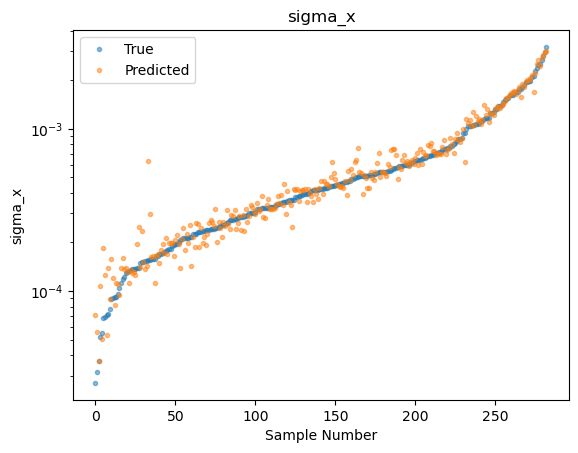

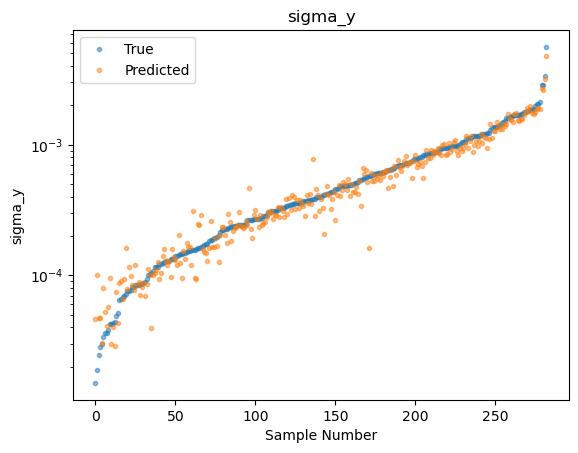

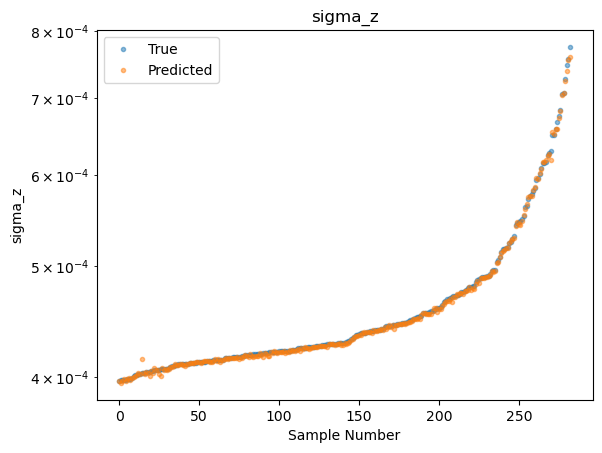

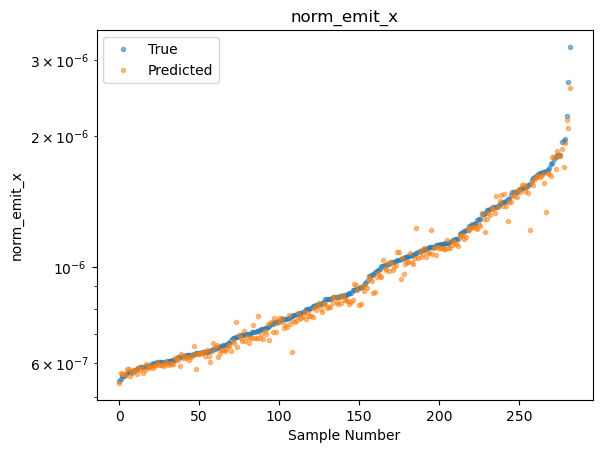

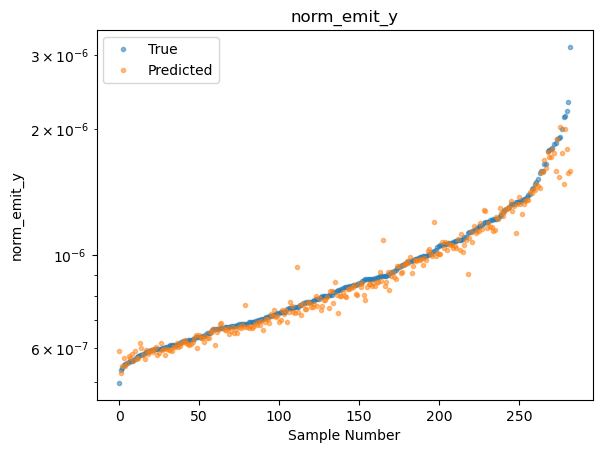

In [65]:
 for i in range(0,Y_true.shape[1]):
    idx=np.argsort(Y_true[:,i])
    plt.plot(Y_true[idx,i],'.',alpha=0.5)
    plt.plot(Y_pred[idx,i],'.',alpha=0.5)
    plt.yscale('log')
    plt.title(surrogate.outputs[i])
    plt.ylabel(surrogate.outputs[i])
    plt.xlabel('Sample Number')
    plt.legend(['True','Predicted'])
    plt.show()

<a id="predict_machine"></a>
# Model Predict with Machine Unit Inputs

In [83]:
#Get some machine unit values by converting
X_true_pv = sim_to_machine(np.asarray(X_true))

In [85]:
#Y_pred_pv = Model.pred_machine_units(X_true_pv);
Y_pred_pv = Model(torch.from_numpy(X_true_pv))

In [87]:
#Y_pred_sim = Model.pred_sim_units(X_true);
Y_pred_sim = Model(torch.from_numpy(X_true))

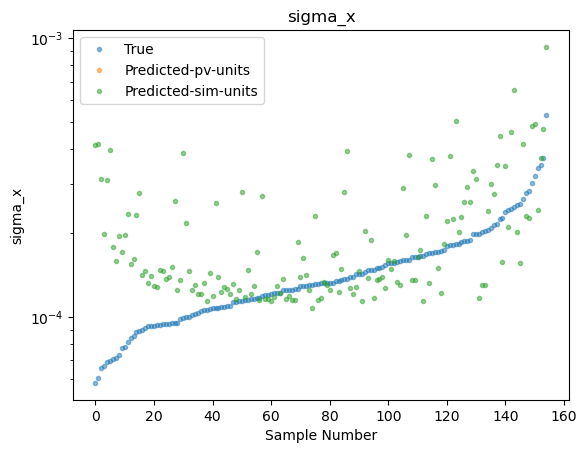

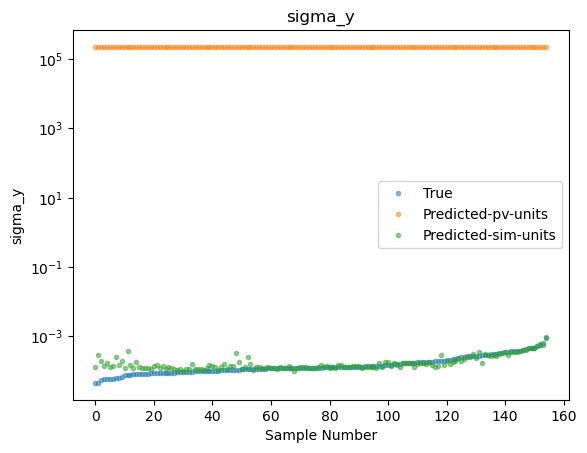

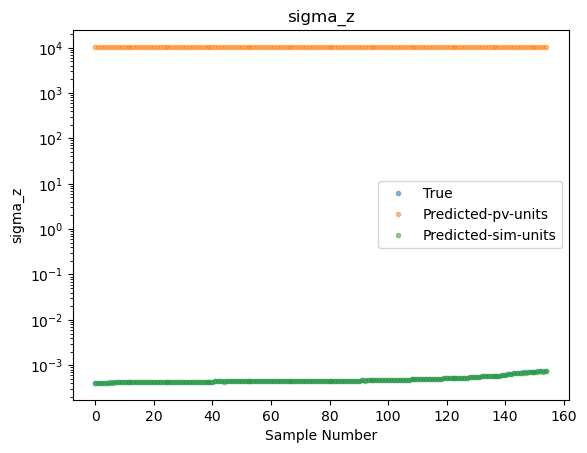

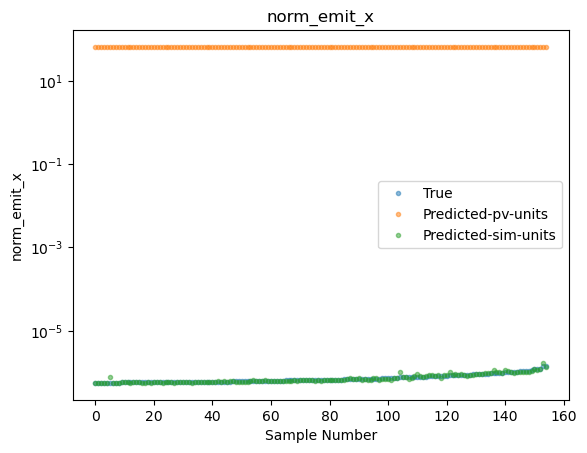

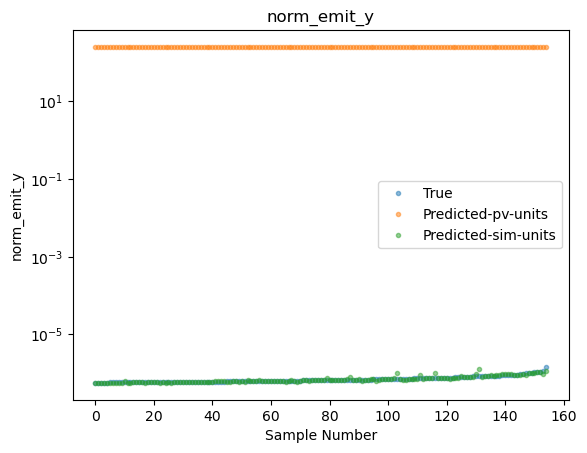

In [89]:
 for i in range(0,Y_true.shape[1]):
    idx=np.argsort(Y_true[:,i])
    plt.plot(Y_true[idx,i],'.',alpha=0.5)
    plt.plot(Y_pred_pv[idx,i],'.',alpha=0.5)
    plt.plot(Y_pred_sim[idx,i],'.',alpha=0.5)
    plt.yscale('log')
    plt.title(surrogate.outputs[i])
    plt.ylabel(surrogate.outputs[i])
    plt.xlabel('Sample Number')
    plt.legend(['True','Predicted-pv-units','Predicted-sim-units'])
    plt.show()

### load some nominally optimal points from simulation to run

In [90]:
scanlist=[
'scan_SOL1:solenoid_field_scale-fine2.json',
'scan_SQ01:b1_gradient-fine2.json',
'scan_CQ01:b1_gradient-fine2.json',]

#load from first scan
dat1 = json.load(open(PATH+scanlist[0]))
inputs=pd.DataFrame(dat1['inputs'])
outputs=pd.DataFrame(dat1['outputs'])

#select only model inputs and outputs
inputs = inputs[Model.model_in_list];

#for this run looking at slightly z in simulation, model will be off a bit
model_out_list2=['end_'+s for s in Model.model_out_list]

outputs = outputs[model_out_list2];

#select first row
ref_input_values = np.asarray(inputs[0:1])


AttributeError: 'LUMEModule' object has no attribute 'model_in_list'

In [93]:
# make predictions
Y_pred = Model.pred_sim_units(ref_input_values)

In [94]:
for out in model_out_list:
    print(out,' ', Y_pred[:,loc_out[out]])

sigma_x   [0.00014783]
sigma_y   [0.00097134]
sigma_z   [0.00043935]
norm_emit_x   [1.7894375e-06]
norm_emit_y   [1.93086e-06]


### predict for some nominal running values of laser

In [95]:
#nominal values for 2/18/2021 measured
pv_lrad = 1.2 #mm
pv_pl = 2 #ps
# charge 250 pc
# bunch length  600um --> 2ps , might be closer to 4

In [96]:
#convert to sim 
print(pv_lrad*pv_to_sim_factor['IRIS:LR20:130:CONFG_SEL'])
print(pv_pl*pv_to_sim_factor['Pulse_length'] )#no real PV for this

0.39999996
3.3


In [97]:
#copy nominal input values optimal from sim
md_values = pd.DataFrame.copy(inputs[0:1])

In [98]:
md_values[:][pv_name_to_sim_name['Pulse_length']] = pv_pl*pv_to_sim_factor['Pulse_length']
md_values[:][pv_name_to_sim_name['IRIS:LR20:130:CONFG_SEL']] = pv_lrad*pv_to_sim_factor['IRIS:LR20:130:CONFG_SEL']

In [99]:
# make predictions
# convert dataframe to array first
Y_pred = Model.pred_sim_units(np.asarray(md_values))

for out in model_out_list:
    print(out,' ', Y_pred[:,loc_out[out]])

sigma_x   [0.00014663]
sigma_y   [0.00097031]
sigma_z   [0.00045048]
norm_emit_x   [1.802781e-06]
norm_emit_y   [1.9316924e-06]


In [100]:
md_values = np.asarray(md_values)



<a id="scan"></a>



# Compare with 1-D Scans from Simulation Around Optimum 
### (likely not well-sampled in training)

In [101]:
def do_scan(scan_var = 'SOL1:solenoid_field_scale',     
                scan_range =[0.23, 0.26],#[0.43, 0.46],
                ref_point = [[ 4.23867825e-01,
                              3.06083484e+00,
                              2.50000000e+02,
                              2.45806452e-01,
                              7.13917676e-04,
                              3.27285211e-04,
                              5.80000000e+07,
                              -9.53597349e+00,
                              7.00000000e+07,
                                9.85566222e+00]],
                units = 'sim',
                numscan = 100,
                Model = Model,
                plot = True,
                plot_keys = ['norm_emit_x']):

        x_scan = np.empty((numscan,len(Model.model_in_list)))

        x_scan[:,:] = np.asarray(ref_point)

        scan = np.linspace(scan_range[0],scan_range[1],numscan)

        x_scan[:, Model.loc_in[scan_var]] = scan

        if units == 'sim':
            Y_pred = Model.pred_sim_units(x_scan)

        #if units == 'machine':

         #   x_scan = machine_to_sim(x_scan)
         #   Y_pred = Model.pred_machine_units(x_scan)

        if plot:
            for key in plot_keys:
                plt.plot(x_scan[:,Model.loc_in[scan_var]],Y_pred[:,Model.loc_out[key]],'.')
                plt.ylabel(key)
                plt.xlabel(scan_var)
                plt.legend(['Neural Network Predictions'])
                plt.show()

        return x_scan, Y_pred


In [102]:
scanvar = 'SOL1:solenoid_field_scale'

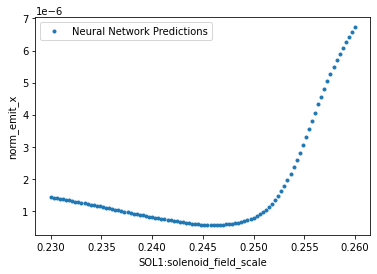

In [103]:
X_scan,Y_pred = do_scan(scanvar,scan_range =[0.23, 0.26], ref_point=md_values);

## Load some simulation scan data to compare with

In [104]:
sim_scanpath = './'
sim_scan_idx={'SOL1:solenoid_field_scale':[0,32],'SQ01:b1_gradient':[32,64],'CQ01:b1_gradient':[64,96]}

sim_outputs = np.load(sim_scanpath+'scan_scalar_out_OTR2.npy',allow_pickle=True)

sim_inputs = np.load(sim_scanpath+'scan_scalar_in.npy',allow_pickle=True)

sim_inputs = pd.DataFrame(sim_inputs,columns=input_names)

sim_outputs = pd.DataFrame(sim_outputs,columns=output_names)

In [105]:
min_emit = 5.461418942827289e-07

### scan 'SOL1:solenoid_field_scale'

In [106]:
#plt.plot(sim_inputs[scan_idx[scanvar][0]:scan_idx[scanvar][1]][scanvar]*sim_to_pv_factor[scanvar],sim_outputs[scan_idx[scanvar][0]:scan_idx[scanvar][1]]['norm_emit_x']*10**6,'.')
#plt.plot(X_scan[:,loc_in[scanvar]]*sim_to_pv_factor[scanvar],Y_pred[:,loc_out['norm_emit_y']]*10**6,'.')
#plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
#plt.xlabel('Solenoid Field (kG*m)')
#plt.legend(['Simulation','Neural Network'])
#plt.ylim([min_emit*10**6,1])
#plt.show()

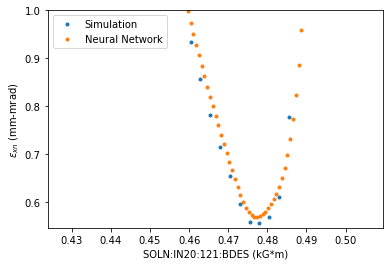

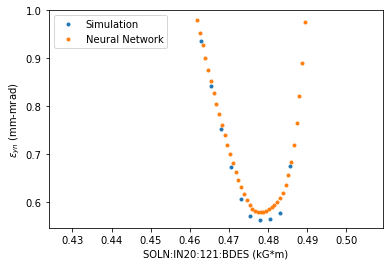

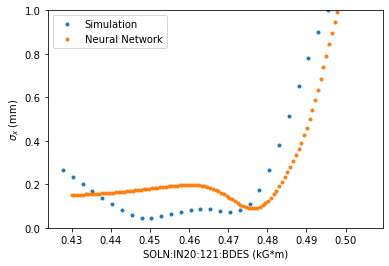

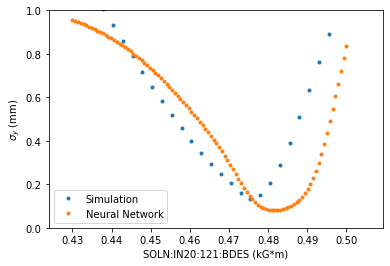

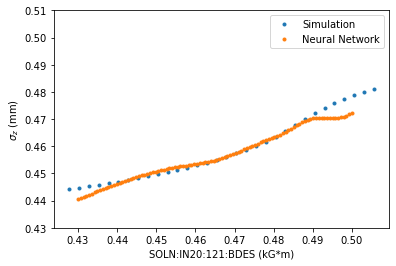

In [107]:
#sett scan
scanvar = 'SOL1:solenoid_field_scale'
scan_range_pv = [0.43/sim_to_pv_factor[scanvar], 0.5/sim_to_pv_factor[scanvar]]

#do scan
X_scan,Y_pred = do_scan(scanvar,scan_range = scan_range_pv, plot = False );

#convert data
X_scan = X_scan[:,loc_in[scanvar]]*sim_to_pv_factor[scanvar]
X_data = sim_inputs[sim_scan_idx[scanvar][0]:sim_scan_idx[scanvar][1]][scanvar]*sim_to_pv_factor[scanvar]
Y_data = sim_outputs[sim_scan_idx[scanvar][0]:sim_scan_idx[scanvar][1]]

#plot
xlabel = sim_name_to_pv_name[scanvar] +' '+ pv_unit[sim_name_to_pv_name[scanvar]]
plot_multiple_comparison(scanvar,X_scan,Y_pred, X_data, Y_data, xlabel, leg = ['Simulation', 'Neural Network'], min_emit= min_emit )

### scan 'SQ01:b1_gradient'

In [108]:
#plt.plot(inputs[scan_idx[scanvar][0]:scan_idx[scanvar][1]][scanvar]*sim_to_pv_factor[scanvar],outputs[scan_idx[scanvar][0]:scan_idx[scanvar][1]]['norm_emit_y']*10**6,'.')
#plt.plot(X_scan[:,loc_in[scanvar]]*sim_to_pv_factor[scanvar],Y_pred[:,loc_out['norm_emit_y']]*10**6,'.')
#plt.ylim([min_emit*10**6,1])
#plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
#plt.xlabel('SQ01 Skew Quad Gradient (kG)')
#plt.legend(['Simulation','Neural Network'])
#plt.show()

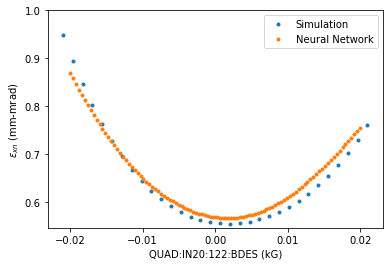

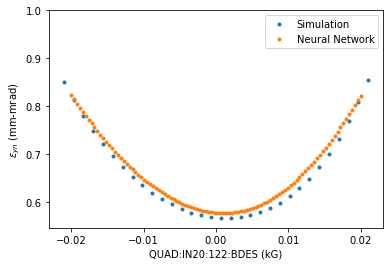

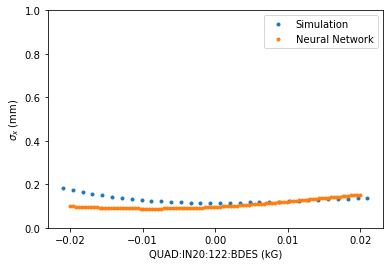

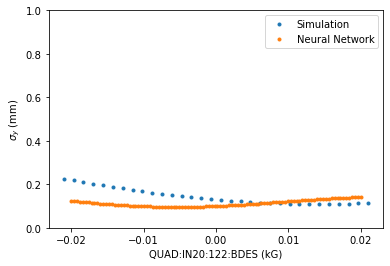

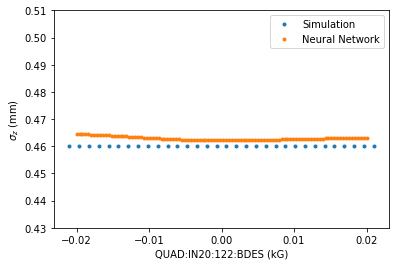

In [109]:
#set scan
scanvar = 'SQ01:b1_gradient'
scan_range_pv = [-0.02/sim_to_pv_factor[scanvar], 0.02/sim_to_pv_factor[scanvar]]

#do scan
X_scan,Y_pred = do_scan(scanvar,scan_range = scan_range_pv,plot=False );

#convert data
X_scan = X_scan[:,loc_in[scanvar]]*sim_to_pv_factor[scanvar]
X_data = sim_inputs[sim_scan_idx[scanvar][0]:sim_scan_idx[scanvar][1]][scanvar]*sim_to_pv_factor[scanvar]
Y_data = sim_outputs[sim_scan_idx[scanvar][0]:sim_scan_idx[scanvar][1]]

#plot
xlabel = sim_name_to_pv_name[scanvar] +' '+ pv_unit[sim_name_to_pv_name[scanvar]]
plot_multiple_comparison(scanvar,X_scan,Y_pred, X_data, Y_data, xlabel, leg = ['Simulation', 'Neural Network'] )

### scan 'CQ01:b1_gradient'

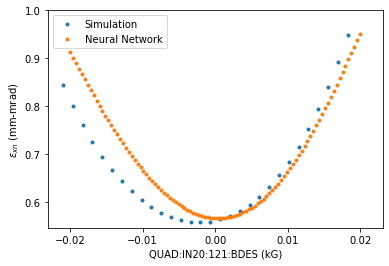

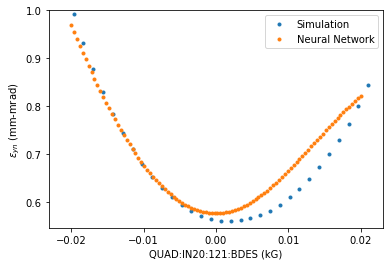

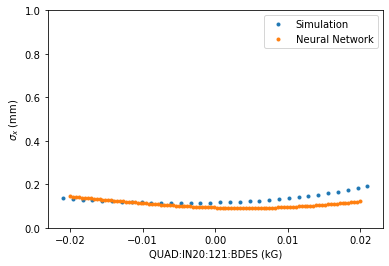

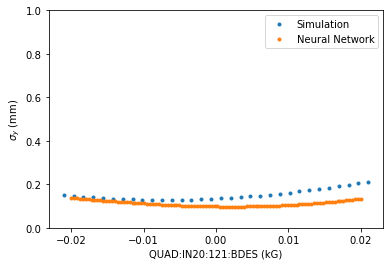

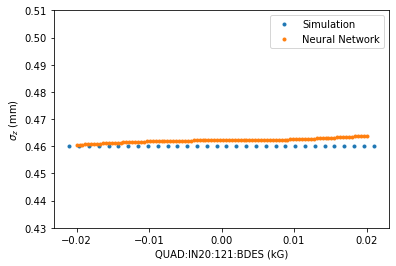

In [110]:
# set scan
scanvar = 'CQ01:b1_gradient'
scan_range_pv = [-0.02/sim_to_pv_factor[scanvar], 0.02/sim_to_pv_factor[scanvar]]

#do scan
X_scan,Y_pred = do_scan(scanvar,scan_range = scan_range_pv,plot=False );

#convert data
X_scan = X_scan[:,loc_in[scanvar]]*sim_to_pv_factor[scanvar]
X_data = sim_inputs[sim_scan_idx[scanvar][0]:sim_scan_idx[scanvar][1]][scanvar]*sim_to_pv_factor[scanvar]
Y_data = sim_outputs[sim_scan_idx[scanvar][0]:sim_scan_idx[scanvar][1]]

#plot
xlabel = sim_name_to_pv_name[scanvar] +' '+ pv_unit[sim_name_to_pv_name[scanvar]]
plot_multiple_comparison(scanvar,X_scan,Y_pred, X_data, Y_data, xlabel, leg = ['Simulation', 'Neural Network'] )



<a id="meas"></a>


# Comparison with some measured data 
(note guessing on some of these inputs other than SQ/CQ/SOL, so not expected to be exact)

In [111]:
emitx = [1.4085,1.4305,1.0905, 0.7137,0.5358, 0.5075,0.6359,1.1666,2.4465]
emity = [2.5192, 1.7998, 0.6448, 0.6579, 0.5244, 0.5686, 0, 2.5051, 11.7213]

In [112]:
#CQ and SQ and SO
c=-0.0024
s=0
sol=np.asarray([0.440000000000000,0.445000000000000,
                0.450000000000000,0.455000000000000,
                0.460000000000000,0.465000000000000,
                0.470000000000000,0.475000000000000,0.480000000000000])

Text(0.5, 1.0, 'Measured Corr Plot')

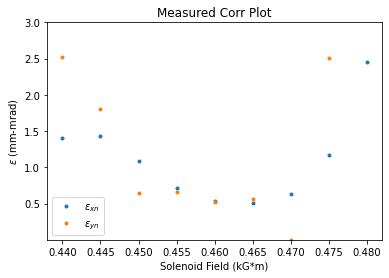

In [131]:
plt.plot(sol,emitx,'.')
plt.plot(sol,emity,'.')
plt.ylabel(r'$\epsilon$ (mm-mrad)')
plt.xlabel('Solenoid Field (kG*m)')
plt.ylim([4e-7,3])
plt.legend([r'$\epsilon_{xn}$',r'$\epsilon_{yn}$ '])
plt.title('Measured Corr Plot')

In [120]:
# run NN scan
scanvar = 'SOL1:solenoid_field_scale'
scan_range_pv = [0.43/sim_to_pv_factor[scanvar], 0.501/sim_to_pv_factor[scanvar]]
X_scan,Y_pred = do_scan(scanvar,scan_range = scan_range_pv,plot=False );
X_scan = X_scan[:,loc_in[scanvar]]*sim_to_pv_factor[scanvar]

In [121]:
# sim scan data
X_sim_data = sim_inputs[sim_scan_idx[scanvar][0]:sim_scan_idx[scanvar][1]][scanvar]*sim_to_pv_factor[scanvar]
Y_sim_data = sim_outputs[sim_scan_idx[scanvar][0]:sim_scan_idx[scanvar][1]]
xlabel = sim_name_to_pv_name[scanvar] +' '+ pv_unit[sim_name_to_pv_name[scanvar]]

### Emit X

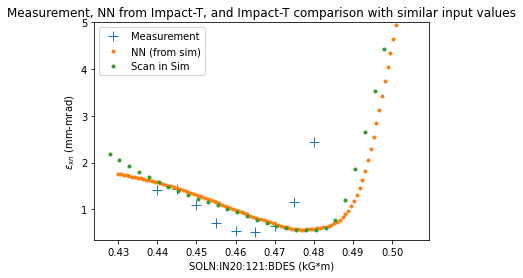

In [132]:
plt.plot(sol,emitx,'+',markersize=10)
plt.plot(X_scan, Y_pred[:,loc_out['norm_emit_x']]*10**6,'.')
plt.plot(X_sim_data, Y_sim_data['norm_emit_x']*10**6,'.')
plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
xlabel = sim_name_to_pv_name[scanvar] +' '+ pv_unit[sim_name_to_pv_name[scanvar]]
plt.xlabel(xlabel)
plt.ylim([0.35,5])
plt.legend(['Measurement','NN (from sim)','Scan in Sim'])
plt.title("Measurement, NN from Impact-T, and Impact-T comparison with similar input values")
plt.show()

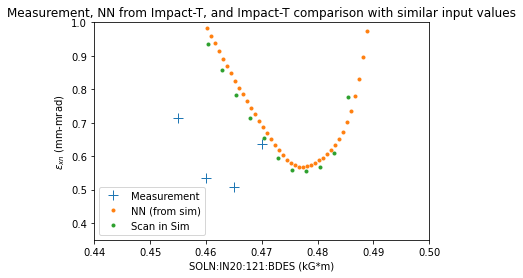

In [133]:
plt.plot(sol,emitx,'+',markersize=10)
plt.plot(X_scan, Y_pred[:,loc_out['norm_emit_x']]*10**6,'.')
plt.plot(X_sim_data, Y_sim_data['norm_emit_x']*10**6,'.')
plt.ylabel(r'$\epsilon_{xn}$ (mm-mrad)')
xlabel = sim_name_to_pv_name[scanvar] +' '+ pv_unit[sim_name_to_pv_name[scanvar]]
plt.xlabel(xlabel)
plt.ylim([0.35,1])
plt.xlim([0.44,0.50])
plt.legend(['Measurement','NN (from sim)','Scan in Sim'])
plt.title("Measurement, NN from Impact-T, and Impact-T comparison with similar input values")
plt.show()

### Emit Y

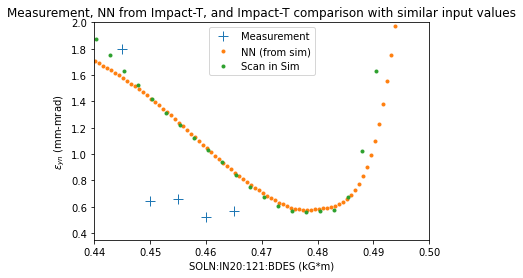

In [134]:
plt.plot(sol,emity,'+',markersize=10)
plt.plot(X_scan, Y_pred[:,loc_out['norm_emit_y']]*10**6,'.')
plt.plot(X_sim_data, Y_sim_data['norm_emit_y']*10**6,'.')
plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
xlabel = sim_name_to_pv_name[scanvar] +' '+ pv_unit[sim_name_to_pv_name[scanvar]]
plt.xlabel(xlabel)
plt.ylim([0.35,2])
plt.xlim([0.44,0.50])
plt.legend(['Measurement','NN (from sim)','Scan in Sim'])
plt.title("Measurement, NN from Impact-T, and Impact-T comparison with similar input values")
plt.show()

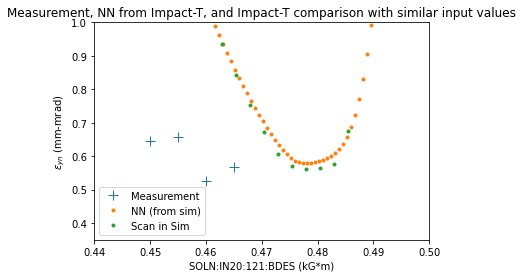

In [137]:
plt.plot(sol,emity,'+',markersize=10)
plt.plot(X_scan, Y_pred[:,loc_out['norm_emit_y']]*10**6,'.')
plt.plot(X_sim_data, Y_sim_data['norm_emit_y']*10**6,'.')
plt.ylabel(r'$\epsilon_{yn}$ (mm-mrad)')
xlabel = sim_name_to_pv_name[scanvar] +' '+ pv_unit[sim_name_to_pv_name[scanvar]]
plt.xlabel(xlabel)
plt.ylim([0.35,1])
plt.xlim([0.44,0.50])
plt.legend(['Measurement','NN (from sim)','Scan in Sim'])
plt.title("Measurement, NN from Impact-T, and Impact-T comparison with similar input values")
plt.show()

### Geometric Mean

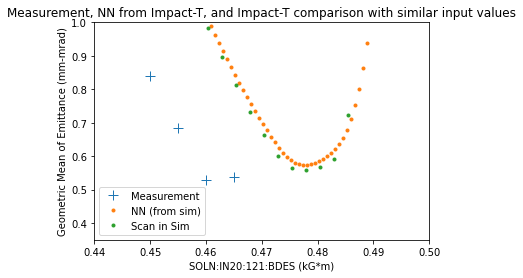

In [136]:
plt.plot(sol,np.sqrt(np.array(emity)*np.array(emitx)),'+',markersize=10)
plt.plot(X_scan, np.sqrt((Y_pred[:,loc_out['norm_emit_x']]*10**6)*(Y_pred[:,loc_out['norm_emit_y']]*10**6)),'.')
plt.plot(X_sim_data, ((np.asarray(Y_sim_data['norm_emit_x'])*10**6)*(np.asarray(Y_sim_data['norm_emit_y'])*10**6))**(1/2),'.')
plt.ylabel('Geometric Mean of Emittance (mm-mrad)')
xlabel = sim_name_to_pv_name[scanvar] +' '+ pv_unit[sim_name_to_pv_name[scanvar]]
plt.xlabel(xlabel)
plt.ylim([0.35,1])
plt.xlim([0.44,0.50])
plt.legend(['Measurement','NN (from sim)','Scan in Sim'])
plt.title("Measurement, NN from Impact-T, and Impact-T comparison with similar input values")
plt.show()

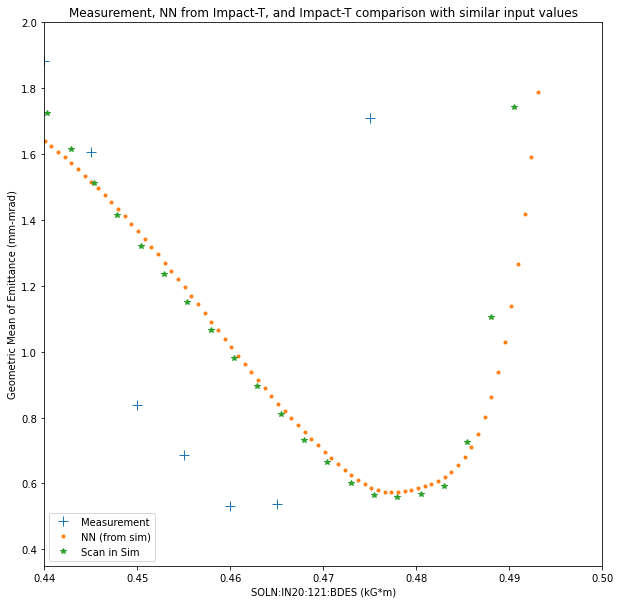

In [138]:
plt.figure(figsize = (10,10))
plt.plot(sol,np.sqrt(np.array(emity)*np.array(emitx)),'+', markersize=10)
plt.plot(X_scan, np.sqrt((Y_pred[:,loc_out['norm_emit_x']]*10**6)*(Y_pred[:,loc_out['norm_emit_y']]*10**6)),'.')
plt.plot(X_sim_data, ((np.asarray(Y_sim_data['norm_emit_x'])*10**6)*(np.asarray(Y_sim_data['norm_emit_y'])*10**6))**(1/2),'*')
plt.ylabel('Geometric Mean of Emittance (mm-mrad)')
xlabel = sim_name_to_pv_name[scanvar] +' '+ pv_unit[sim_name_to_pv_name[scanvar]]
plt.xlabel(xlabel)
plt.ylim([0.35,2])
plt.xlim([0.44,0.50])
plt.legend(['Measurement','NN (from sim)','Scan in Sim'])
plt.title("Measurement, NN from Impact-T, and Impact-T comparison with similar input values")
plt.show()

<a id="BO"></a>
# Small BO Run

In [139]:

ref_point = [[4.23867825e-01,
                      3.06083484e+00,
                      2.50000000e+02,
                      2.45806452e-01,
                      7.13917676e-04,
                      3.27285211e-04,
                      5.80000000e+07,
                      -9.53597349e+00,
                      7.00000000e+07,
                        9.85566222e+00]]

opt_var_names = ['SOL1:solenoid_field_scale','SQ01:b1_gradient','CQ01:b1_gradient']
opt_out_names = ['norm_emit_x','norm_emit_y']

def evaluate(varx,vary,varz):

    x_in = np.empty((1,len(Model.model_in_list)))

    x_in[:,:] = np.asarray(ref_point)

    x_in[:, Model.loc_in[opt_var_names[0]]] = varx
    x_in[:, Model.loc_in[opt_var_names[1]]] = vary
    x_in[:, Model.loc_in[opt_var_names[2]]] = varz

    y_out = Model.pred_sim_units(x_in)

    return -1*objective(y_out)[0]


def objective(y_out):
    out1 = y_out[:,loc_out['norm_emit_x']]
    out2 = y_out[:,loc_out['norm_emit_y']]
    
    return np.sqrt(out1*out2)


In [158]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'varx': (0.44/sim_to_pv_factor['SOL1:solenoid_field_scale'], 0.501/sim_to_pv_factor['SOL1:solenoid_field_scale']),
           'vary': (0.02/sim_to_pv_factor['CQ01:b1_gradient'], -0.02/sim_to_pv_factor['CQ01:b1_gradient']),
           'varz': (0.02/sim_to_pv_factor['SQ01:b1_gradient'], -0.02/sim_to_pv_factor['SQ01:b1_gradient'])}

optimizer = BayesianOptimization(
    f = evaluate,
    pbounds = pbounds,
    random_state = 1,
)

optimizer.maximize(
    init_points=5,
    n_iter=40,
)

|   iter    |  target   |   varx    |   vary    |   varz    |
-------------------------------------------------------------
|  1        | -9.84e-07 |  0.2394   |  0.004197 | -0.009522 |
|  2        | -1.301e-0 |  0.2358   | -0.006728 | -0.007765 |
|  3        | -1.344e-0 |  0.2321   | -0.002942 | -0.001966 |
|  4        | -6.544e-0 |  0.2432   | -0.001539 |  0.003528 |
|  5        | -1.206e-0 |  0.2327   |  0.007202 | -0.009002 |
|  6        | -6.406e-0 |  0.2469   | -6.23e-05 |  0.003531 |
|  7        | -1.223e-0 |  0.2509   | -0.00848  |  0.009498 |
|  8        | -8.468e-0 |  0.244    |  0.006464 |  0.004021 |
|  9        | -1.238e-0 |  0.2334   | -0.00656  |  0.00852  |
|  10       | -6.803e-0 |  0.2484   |  0.000307 | -0.003505 |
|  11       | -7.368e-0 |  0.241    | -0.001457 | -0.000535 |
|  12       | -3.003e-0 |  0.2572   |  0.009328 | -0.007154 |
|  13       | -1.178e-0 |  0.2416   |  0.006499 |  0.009125 |
|  14       | -1.319e-0 |  0.2364   |  0.00502  |  0.006799 |
|  15   

In [159]:
optimizer.max

{'target': -5.715045858778467e-07,
 'params': {'varx': 0.24553601782882611,
  'vary': 0.00041663776353420556,
  'varz': 0.00019491073508442688}}

In [160]:
SOL_opt = optimizer.max['params']['varx']*sim_to_pv_factor['SOL1:solenoid_field_scale']
CQ_opt = optimizer.max['params']['vary']*sim_to_pv_factor['CQ01:b1_gradient']
SQ_opt = optimizer.max['params']['varz']*sim_to_pv_factor['SQ01:b1_gradient']
print('optimum (pv_units) ',SOL_opt, CQ_opt, SQ_opt)

optimum (pv_units)  0.4774434876924299 -0.0008749393037718074 -0.0004093125438410215


In [161]:
opt_emit = -1*optimizer.max['target']
print('optimum geom emit ', opt_emit)

optimum geom emit  5.715045858778467e-07


In [162]:
# update point around which to scan 
opt_ref_point =  [[ 4.23867825e-01,
    3.06083484e+00,
    2.50000000e+02,
    2.45806452e-01,
    7.13917676e-04,
    3.27285211e-04,
    5.80000000e+07,
    -9.53597349e+00,
    7.00000000e+07,
    9.85566222e+00]]

opt_ref_point[0][loc_in['SOL1:solenoid_field_scale']] = optimizer.max['params']['varx']
opt_ref_point[0][loc_in['CQ01:b1_gradient']] = optimizer.max['params']['vary']
opt_ref_point[0][loc_in['SQ01:b1_gradient']] = optimizer.max['params']['varz']

In [163]:
# set scan
scanvar = 'SOL1:solenoid_field_scale'
scan_range_pv = [0.44/sim_to_pv_factor['SOL1:solenoid_field_scale'], 0.501/sim_to_pv_factor['SOL1:solenoid_field_scale']]

#do scan
X_scan,Y_pred = do_scan(scanvar,scan_range = scan_range_pv, ref_point=opt_ref_point, plot=False);

#convert data
X_scan = X_scan[:,loc_in[scanvar]]*sim_to_pv_factor[scanvar]
X_data = sim_inputs[sim_scan_idx[scanvar][0]:sim_scan_idx[scanvar][1]][scanvar]*sim_to_pv_factor[scanvar]
Y_data = sim_outputs[sim_scan_idx[scanvar][0]:sim_scan_idx[scanvar][1]]

#plot
xlabel = sim_name_to_pv_name[scanvar] +' '+ pv_unit[sim_name_to_pv_name[scanvar]]

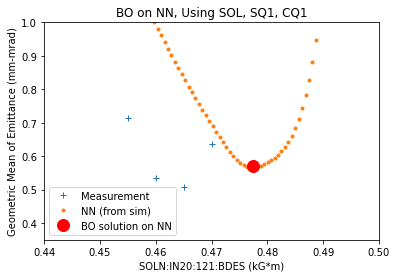

In [164]:
plt.plot(sol,emitx,'+')
plt.plot(X_scan, np.sqrt((Y_pred[:,loc_out['norm_emit_x']]*10**6)*(Y_pred[:,loc_out['norm_emit_x']]*10**6)),'.')
plt.plot(SOL_opt,opt_emit*10**6,'ro',markersize = 12)
plt.ylabel('Geometric Mean of Emittance (mm-mrad)')
xlabel = sim_name_to_pv_name[scanvar] +' '+ pv_unit[sim_name_to_pv_name[scanvar]]
plt.xlabel(xlabel)
plt.ylim([0.35,1])
plt.xlim([0.44,0.50])
plt.legend(['Measurement','NN (from sim)','BO solution on NN'])
plt.title('BO on NN, Using SOL, SQ1, CQ1')
plt.show()

In [165]:
# set scan
scanvar = 'CQ01:b1_gradient'
scan_range_pv = [-0.02/sim_to_pv_factor[scanvar], 0.02/sim_to_pv_factor[scanvar]]

#do scan
X_scan,Y_pred = do_scan(scanvar,scan_range = scan_range_pv, ref_point=opt_ref_point, plot=False);

#convert data
X_scan = X_scan[:,loc_in[scanvar]]*sim_to_pv_factor[scanvar]
X_data = sim_inputs[sim_scan_idx[scanvar][0]:sim_scan_idx[scanvar][1]][scanvar]*sim_to_pv_factor[scanvar]
Y_data = sim_outputs[sim_scan_idx[scanvar][0]:sim_scan_idx[scanvar][1]]

#plot
xlabel = sim_name_to_pv_name[scanvar] +' '+ pv_unit[sim_name_to_pv_name[scanvar]]

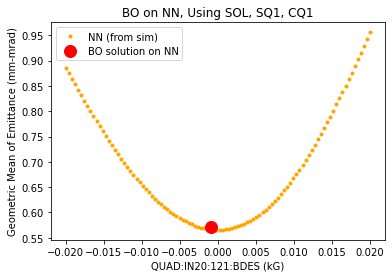

In [166]:
plt.plot(X_scan, np.sqrt((Y_pred[:,loc_out['norm_emit_x']]*10**6)*(Y_pred[:,loc_out['norm_emit_x']]*10**6)),'.',color='orange')
plt.plot(CQ_opt,opt_emit*10**6,'ro',markersize = 12)
plt.ylabel('Geometric Mean of Emittance (mm-mrad)')
xlabel = sim_name_to_pv_name[scanvar] +' '+ pv_unit[sim_name_to_pv_name[scanvar]]
plt.xlabel(xlabel)
plt.legend(['NN (from sim)','BO solution on NN'])
plt.title('BO on NN, Using SOL, SQ1, CQ1')
plt.show()

In [167]:
# set scan
scanvar = 'SQ01:b1_gradient'
scan_range_pv = [-0.02/sim_to_pv_factor[scanvar], 0.02/sim_to_pv_factor[scanvar]]

#do scan
X_scan,Y_pred = do_scan(scanvar,scan_range = scan_range_pv, ref_point=opt_ref_point, plot=False);

#convert data
X_scan = X_scan[:,loc_in[scanvar]]*sim_to_pv_factor[scanvar]
X_data = sim_inputs[sim_scan_idx[scanvar][0]:sim_scan_idx[scanvar][1]][scanvar]*sim_to_pv_factor[scanvar]
Y_data = sim_outputs[sim_scan_idx[scanvar][0]:sim_scan_idx[scanvar][1]]

#plot
xlabel = sim_name_to_pv_name[scanvar] +' '+ pv_unit[sim_name_to_pv_name[scanvar]]

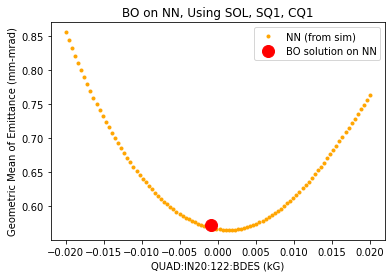

In [168]:
plt.plot(X_scan, np.sqrt((Y_pred[:,loc_out['norm_emit_x']]*10**6)*(Y_pred[:,loc_out['norm_emit_x']]*10**6)),'.',color='orange')
plt.plot(CQ_opt,opt_emit*10**6,'ro',markersize = 12)
plt.ylabel('Geometric Mean of Emittance (mm-mrad)')
xlabel = sim_name_to_pv_name[scanvar] +' '+ pv_unit[sim_name_to_pv_name[scanvar]]
plt.xlabel(xlabel)
plt.legend(['NN (from sim)','BO solution on NN'])
plt.title('BO on NN, Using SOL, SQ1, CQ1')
plt.show()

## Plot With Uncertainty Just for Solenoid Opt

In [192]:
def evaluate_sol(varx):

    x_in = np.empty((1,len(Model.model_in_list)))

    x_in[:,:] = np.asarray(ref_point)

    x_in[:, Model.loc_in[opt_var_names[0]]] = varx

    y_out = Model.pred_sim_units(x_in)

    return -1*objective(y_out)[0]

def evaluate_sol2(varx):

    x_in = np.empty((varx.shape[0],len(Model.model_in_list)))

    x_in[:,:] = np.asarray(ref_point)

    x_in[:, Model.loc_in[opt_var_names[0]]] = varx

    y_out = Model.pred_sim_units(x_in)

    return -1*objective(y_out)

In [193]:
def plot_bo(f, bo):
    x = np.linspace(0.44/sim_to_pv_factor['SOL1:solenoid_field_scale'], 0.501/sim_to_pv_factor['SOL1:solenoid_field_scale'], 10000)
    mean, sigma = bo._gp.predict(x.reshape(-1, 1), return_std=True)
    
    x2 = np.linspace(0.44, 0.501, 10000)
   
    plt.figure(figsize=(10, 6))
    plt.plot(x2, -1*f(x)*10**6)
    plt.plot(x2, -1*mean*10**6)
    plt.xlabel('SOLN:IN20:121:BDES (kG*m)')
    plt.ylabel('Objective - Geometric Mean of Emit (mm-mrad)')
    plt.fill_between(x2, -1*mean*10**6 + sigma*10**6, -1*mean*10**6 - sigma*10**6, alpha=0.1)
    plt.scatter(bo.space.params.flatten()*sim_to_pv_factor['SOL1:solenoid_field_scale'], -1*bo.space.target*10**6, c="red", s=50, zorder=10)
    plt.legend(['NN Surrogate','GP mean','sigma','Acquisitions'])
    
    plt.show()

In [194]:
bo = BayesianOptimization(
    f=evaluate_sol,
    pbounds={'varx': (0.44/sim_to_pv_factor['SOL1:solenoid_field_scale'], 0.501/sim_to_pv_factor['SOL1:solenoid_field_scale'])},
    verbose=0,
    random_state=987234,
)


In [195]:
bo.maximize(n_iter=3, acq="ucb", init_points=5)

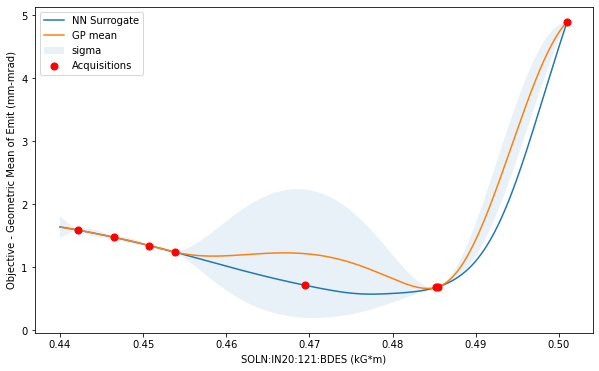

In [196]:
plot_bo(evaluate_sol2, bo)

In [119]:
runvals = pd.read_pickle('emit.pkl')

In [47]:
runvals

,time,SOLN:IN20:121:BACT,QUAD:IN20:121:BACT,QUAD:IN20:122:BACT,OTRS:IN20:571:EMITN_X,OTRS:IN20:571:EMITN_Y
868646,2021-01-20 17:40:55,0.464907,0.008758,0.003615,0.521783,0.354604
868647,2021-01-20 17:40:57,0.464908,0.008756,0.003616,0.521783,0.354604
1128381,2021-01-26 02:24:01,0.464915,0.008760,0.003615,0.451390,0.445449
1128382,2021-01-26 02:24:03,0.464915,0.008760,0.003616,0.451390,0.445449
1128714,2021-01-26 02:33:47,0.464915,0.008760,0.003615,0.424185,0.394232
...,...,...,...,...,...,...
2307127,2021-02-19 08:40:19,0.465400,0.007490,-0.001674,0.619356,0.429704
2307128,2021-02-19 08:40:21,0.465400,0.007490,-0.001674,0.619356,0.429704
2307168,2021-02-19 08:41:32,0.465400,0.007491,-0.001674,0.606180,0.420392
2307207,2021-02-19 08:42:39,0.465401,0.007491,-0.001675,0.579931,0.427551


In [48]:
runvals.shape[0]

254

In [49]:
inputs.columns

Index(['distgen:r_dist:sigma_xy:value', 'distgen:t_dist:length:value',
       'distgen:total_charge:value', 'SOL1:solenoid_field_scale',
       'CQ01:b1_gradient', 'SQ01:b1_gradient', 'L0A_scale:voltage',
       'L0A_phase:dtheta0_deg', 'L0B_scale:voltage', 'L0B_phase:dtheta0_deg'],
      dtype='object')

In [50]:
arch_values = np.empty((runvals.shape[0],len(model_in_list)))

#,columns = ['distgen:r_dist:sigma_xy:value', 'distgen:t_dist:length:value',
#       'distgen:total_charge:value', 'SOL1:solenoid_field_scale',
#       'CQ01:b1_gradient', 'SQ01:b1_gradient', 'L0A_scale:voltage',
#       'L0A_phase:dtheta0_deg', 'L0B_scale:voltage', 'L0B_phase:dtheta0_deg'])

In [51]:
arch_values[:,:]= inputs[0:1]
arch_values = pd.DataFrame(arch_values,columns = ['distgen:r_dist:sigma_xy:value', 'distgen:t_dist:length:value',
       'distgen:total_charge:value', 'SOL1:solenoid_field_scale',
       'CQ01:b1_gradient', 'SQ01:b1_gradient', 'L0A_scale:voltage',
       'L0A_phase:dtheta0_deg', 'L0B_scale:voltage', 'L0B_phase:dtheta0_deg'])

In [52]:
arch_values[:][pv_name_to_sim_name['SOLN:IN20:121:BDES']] = np.array(runvals[:]['SOLN:IN20:121:BACT'])*pv_to_sim_factor['SOLN:IN20:121:BDES']
arch_values[:][pv_name_to_sim_name['QUAD:IN20:121:BDES']] = np.array(runvals[:]['QUAD:IN20:121:BACT'])*pv_to_sim_factor['QUAD:IN20:121:BDES']
arch_values[:][pv_name_to_sim_name['QUAD:IN20:122:BDES']] = np.array(runvals[:]['QUAD:IN20:122:BACT'])*pv_to_sim_factor['QUAD:IN20:122:BDES']

In [53]:
arch_emitx=runvals['OTRS:IN20:571:EMITN_X']#

In [54]:
arch_emity=runvals['OTRS:IN20:571:EMITN_Y']

In [55]:
runvals.shape[0]

254

In [56]:
arch_values

,distgen:r_dist:sigma_xy:value,distgen:t_dist:length:value,distgen:total_charge:value,SOL1:solenoid_field_scale,CQ01:b1_gradient,SQ01:b1_gradient,L0A_scale:voltage,L0A_phase:dtheta0_deg,L0B_scale:voltage,L0B_phase:dtheta0_deg
0,0.423868,3.060835,250.0,0.239089,-0.004170,-0.001721,58000000.0,-9.535973,70000000.0,9.855662
1,0.423868,3.060835,250.0,0.239089,-0.004170,-0.001722,58000000.0,-9.535973,70000000.0,9.855662
2,0.423868,3.060835,250.0,0.239093,-0.004171,-0.001722,58000000.0,-9.535973,70000000.0,9.855662
3,0.423868,3.060835,250.0,0.239093,-0.004171,-0.001722,58000000.0,-9.535973,70000000.0,9.855662
4,0.423868,3.060835,250.0,0.239093,-0.004171,-0.001721,58000000.0,-9.535973,70000000.0,9.855662
...,...,...,...,...,...,...,...,...,...,...
249,0.423868,3.060835,250.0,0.239343,-0.003567,0.000797,58000000.0,-9.535973,70000000.0,9.855662
250,0.423868,3.060835,250.0,0.239342,-0.003567,0.000797,58000000.0,-9.535973,70000000.0,9.855662
251,0.423868,3.060835,250.0,0.239343,-0.003567,0.000797,58000000.0,-9.535973,70000000.0,9.855662
252,0.423868,3.060835,250.0,0.239343,-0.003567,0.000798,58000000.0,-9.535973,70000000.0,9.855662


In [57]:
Y_pred = Model.pred_sim_units(arch_values)

In [58]:
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,250,254),Y_pred[:,loc_out['norm_emit_x']]*10**6,'.')
plt.plot(np.linspace(0,250,254),arch_emitx,'x')
#plt.plot(arch_emitx,'x')
plt.xlabel('Sample (Increasing Time)')
plt.ylabel('Emittance X (mm-mrad)')
plt.legend(['Neural Network (trained on Impact-T)','Measured'])

Error in callback <function flush_figures at 0x7f0921b17820> (for post_execute):


KeyboardInterrupt: 

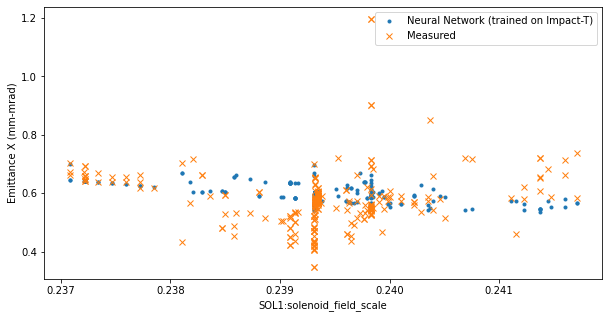

In [59]:
plt.figure(figsize=(10,5))
plt.plot(np.array(arch_values['SOL1:solenoid_field_scale']),Y_pred[:,loc_out['norm_emit_x']]*10**6,'.')
plt.plot(np.array(arch_values['SOL1:solenoid_field_scale']),arch_emitx,'x')
#plt.plot(arch_emitx,'x')
plt.xlabel('SOL1:solenoid_field_scale')
plt.ylabel('Emittance X (mm-mrad)')
plt.legend(['Neural Network (trained on Impact-T)','Measured'])

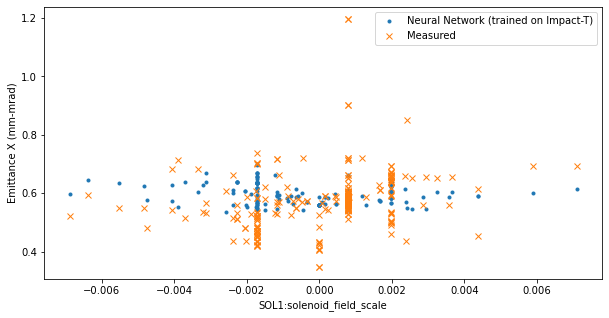

In [60]:
plt.figure(figsize=(10,5))
plt.plot(np.array(arch_values['SQ01:b1_gradient']),Y_pred[:,loc_out['norm_emit_x']]*10**6,'.')
plt.plot(np.array(arch_values['SQ01:b1_gradient']),arch_emitx,'x')
#plt.plot(arch_emitx,'x')
plt.xlabel('SOL1:solenoid_field_scale')
plt.ylabel('Emittance X (mm-mrad)')
plt.legend(['Neural Network (trained on Impact-T)','Measured'])

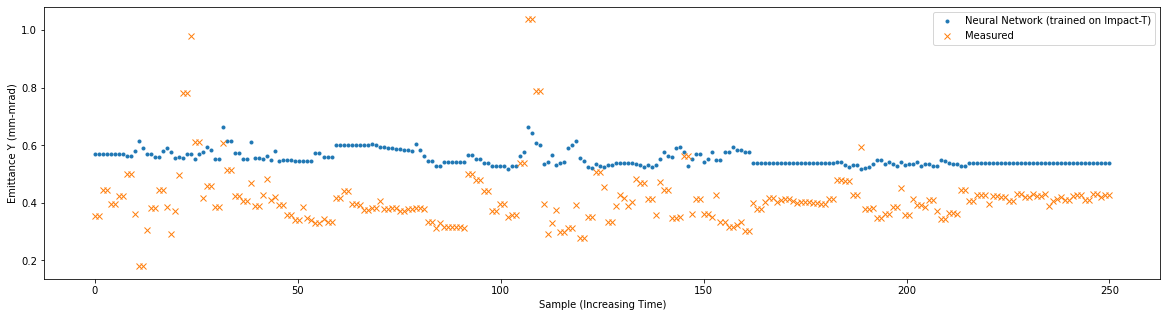

In [61]:
plt.figure(figsize=(20,5))
plt.plot(np.linspace(0,250,254),Y_pred[:,loc_out['norm_emit_y']]*10**6,'.')
plt.plot(np.linspace(0,250,254),arch_emity,'x')
#plt.plot(arch_emitx,'x')
plt.xlabel('Sample (Increasing Time)')
plt.ylabel('Emittance Y (mm-mrad)')
plt.legend(['Neural Network (trained on Impact-T)','Measured'])

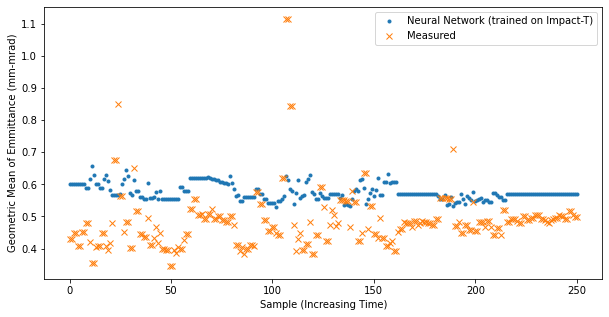

In [62]:
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,250,254),np.sqrt((Y_pred[:,loc_out['norm_emit_x']]*10**6)*(Y_pred[:,loc_out['norm_emit_y']]*10**6)),'.')
plt.plot(np.linspace(0,250,254),np.sqrt(arch_emity*arch_emitx),'x')
#plt.plot(arch_emitx,'x')
plt.xlabel('Sample (Increasing Time)')
plt.ylabel('Geometric Mean of Emmittance (mm-mrad)')
plt.legend(['Neural Network (trained on Impact-T)','Measured'])

In [63]:
runvals = pd.read_pickle('rms.pkl')

In [64]:
runvals

,time,SOLN:IN20:121:BACT,QUAD:IN20:121:BACT,QUAD:IN20:122:BACT,OTRS:IN20:571:XRMS,OTRS:IN20:571:YRMS
1127262,2021-01-26 01:50:48,0.464915,0.008759,0.003615,1.042086,1.042086
1127263,2021-01-26 01:50:50,0.464915,0.008760,0.003616,1.042086,1.042086
1127366,2021-01-26 01:53:54,0.464915,0.008760,0.003616,49.735301,98.245323
1127367,2021-01-26 01:53:55,0.464915,0.008760,0.003615,49.735301,98.245323
1127368,2021-01-26 01:53:57,0.464915,0.008760,0.003616,7.074864,6.744032
...,...,...,...,...,...,...
2311901,2021-02-19 11:01:46,0.465356,0.007500,-0.001683,26.024086,12.763088
2311902,2021-02-19 11:01:48,0.465356,0.007499,-0.001683,26.024086,12.763088
2311913,2021-02-19 11:02:07,0.465355,0.007500,-0.001683,19.738550,32.039121
2311917,2021-02-19 11:02:14,0.465355,0.007500,-0.001682,22.298559,41.364478


In [65]:
runvals.shape[0]

15702

In [66]:
inputs.columns

Index(['distgen:r_dist:sigma_xy:value', 'distgen:t_dist:length:value',
       'distgen:total_charge:value', 'SOL1:solenoid_field_scale',
       'CQ01:b1_gradient', 'SQ01:b1_gradient', 'L0A_scale:voltage',
       'L0A_phase:dtheta0_deg', 'L0B_scale:voltage', 'L0B_phase:dtheta0_deg'],
      dtype='object')

In [67]:


#,columns = ['distgen:r_dist:sigma_xy:value', 'distgen:t_dist:length:value',
#       'distgen:total_charge:value', 'SOL1:solenoid_field_scale',
#       'CQ01:b1_gradient', 'SQ01:b1_gradient', 'L0A_scale:voltage',
#       'L0A_phase:dtheta0_deg', 'L0B_scale:voltage', 'L0B_phase:dtheta0_deg'])

In [68]:
arch_values = np.empty((runvals.shape[0],len(model_in_list)))
arch_values[:,:]= inputs[0:1]
arch_values = pd.DataFrame(arch_values,columns = ['distgen:r_dist:sigma_xy:value', 'distgen:t_dist:length:value',
       'distgen:total_charge:value', 'SOL1:solenoid_field_scale',
       'CQ01:b1_gradient', 'SQ01:b1_gradient', 'L0A_scale:voltage',
       'L0A_phase:dtheta0_deg', 'L0B_scale:voltage', 'L0B_phase:dtheta0_deg'])

arch_values[:][pv_name_to_sim_name['SOLN:IN20:121:BDES']] = np.array(runvals[:]['SOLN:IN20:121:BACT'])*pv_to_sim_factor['SOLN:IN20:121:BDES']
arch_values[:][pv_name_to_sim_name['QUAD:IN20:121:BDES']] = np.array(runvals[:]['QUAD:IN20:121:BACT'])*pv_to_sim_factor['QUAD:IN20:121:BDES']
arch_values[:][pv_name_to_sim_name['QUAD:IN20:122:BDES']] = np.array(runvals[:]['QUAD:IN20:122:BACT'])*pv_to_sim_factor['QUAD:IN20:122:BDES']

In [69]:
arch_xrms=runvals['OTRS:IN20:571:XRMS']#

In [70]:
arch_yrms=runvals['OTRS:IN20:571:YRMS']

In [71]:
runvals.shape[0]

15702

In [72]:
arch_values

,distgen:r_dist:sigma_xy:value,distgen:t_dist:length:value,distgen:total_charge:value,SOL1:solenoid_field_scale,CQ01:b1_gradient,SQ01:b1_gradient,L0A_scale:voltage,L0A_phase:dtheta0_deg,L0B_scale:voltage,L0B_phase:dtheta0_deg
0,0.423868,3.060835,250.0,0.239093,-0.004171,-0.001721,58000000.0,-9.535973,70000000.0,9.855662
1,0.423868,3.060835,250.0,0.239093,-0.004171,-0.001722,58000000.0,-9.535973,70000000.0,9.855662
2,0.423868,3.060835,250.0,0.239093,-0.004171,-0.001722,58000000.0,-9.535973,70000000.0,9.855662
3,0.423868,3.060835,250.0,0.239093,-0.004172,-0.001722,58000000.0,-9.535973,70000000.0,9.855662
4,0.423868,3.060835,250.0,0.239093,-0.004171,-0.001722,58000000.0,-9.535973,70000000.0,9.855662
...,...,...,...,...,...,...,...,...,...,...
15697,0.423868,3.060835,250.0,0.239320,-0.003571,0.000802,58000000.0,-9.535973,70000000.0,9.855662
15698,0.423868,3.060835,250.0,0.239320,-0.003571,0.000802,58000000.0,-9.535973,70000000.0,9.855662
15699,0.423868,3.060835,250.0,0.239319,-0.003572,0.000801,58000000.0,-9.535973,70000000.0,9.855662
15700,0.423868,3.060835,250.0,0.239319,-0.003571,0.000801,58000000.0,-9.535973,70000000.0,9.855662


In [73]:
runvals=pd.read_pickle('corrplots_SOLN:IN20:121:BCTRL.pkl')

In [74]:
runvals.keys()

Index(['run', 'emitx', 'emity', 'betax', 'betay', 'alphax', 'alphay', 'bmagx',
       'bmagy', 'tsMeas', 'tsPV', 'ctrlPV_val', 'ctrlPV_name'],
      dtype='object')

In [75]:
arch_values = np.empty((runvals.shape[0],len(model_in_list)))
arch_values[:,:]= inputs[0:1]
arch_values = pd.DataFrame(arch_values,columns = ['distgen:r_dist:sigma_xy:value', 'distgen:t_dist:length:value',
       'distgen:total_charge:value', 'SOL1:solenoid_field_scale',
       'CQ01:b1_gradient', 'SQ01:b1_gradient', 'L0A_scale:voltage',
       'L0A_phase:dtheta0_deg', 'L0B_scale:voltage', 'L0B_phase:dtheta0_deg'])

arch_values[:][pv_name_to_sim_name['SOLN:IN20:121:BDES']] = np.array(runvals[:]['ctrlPV_val'])*pv_to_sim_factor['SOLN:IN20:121:BDES']


In [76]:
runvals = pd.read_pickle('w-laser2021.pkl')

In [77]:
runvals.shape[0]

207682

In [78]:
inputs.columns

Index(['distgen:r_dist:sigma_xy:value', 'distgen:t_dist:length:value',
       'distgen:total_charge:value', 'SOL1:solenoid_field_scale',
       'CQ01:b1_gradient', 'SQ01:b1_gradient', 'L0A_scale:voltage',
       'L0A_phase:dtheta0_deg', 'L0B_scale:voltage', 'L0B_phase:dtheta0_deg'],
      dtype='object')

In [79]:
arch_values = np.empty((runvals.shape[0],len(model_in_list)))

#,columns = ['distgen:r_dist:sigma_xy:value', 'distgen:t_dist:length:value',
#       'distgen:total_charge:value', 'SOL1:solenoid_field_scale',
#       'CQ01:b1_gradient', 'SQ01:b1_gradient', 'L0A_scale:voltage',
#       'L0A_phase:dtheta0_deg', 'L0B_scale:voltage', 'L0B_phase:dtheta0_deg'])

In [80]:
arch_values[:,:]= inputs[0:1]
arch_values = pd.DataFrame(arch_values,columns = ['distgen:r_dist:sigma_xy:value', 'distgen:t_dist:length:value',
       'distgen:total_charge:value', 'SOL1:solenoid_field_scale',
       'CQ01:b1_gradient', 'SQ01:b1_gradient', 'L0A_scale:voltage',
       'L0A_phase:dtheta0_deg', 'L0B_scale:voltage', 'L0B_phase:dtheta0_deg'])

In [81]:
arch_values[:][pv_name_to_sim_name['SOLN:IN20:121:BDES']] = np.array(runvals[:]['SOLN:IN20:121:BACT'])*pv_to_sim_factor['SOLN:IN20:121:BDES']
arch_values[:][pv_name_to_sim_name['QUAD:IN20:121:BDES']] = np.array(runvals[:]['QUAD:IN20:121:BACT'])*pv_to_sim_factor['QUAD:IN20:121:BDES']
arch_values[:][pv_name_to_sim_name['QUAD:IN20:122:BDES']] = np.array(runvals[:]['QUAD:IN20:122:BACT'])*pv_to_sim_factor['QUAD:IN20:122:BDES']

In [82]:
arch_emitx=runvals['OTRS:IN20:571:EMITN_X']#

KeyError: 'OTRS:IN20:571:EMITN_X'

In [ ]:
arch_emity=runvals['OTRS:IN20:571:EMITN_Y']

In [ ]:
runvals.shape[0]

In [ ]:
arch_values

In [ ]:
Y_pred = Model.pred_sim_units(arch_values)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,250,254),Y_pred[:,loc_out['norm_emit_x']]*10**6,'.')
plt.plot(np.linspace(0,250,254),arch_emitx,'x')
#plt.plot(arch_emitx,'x')
plt.xlabel('Sample (Increasing Time)')
plt.ylabel('Emittance X (mm-mrad)')
plt.legend(['Neural Network (trained on Impact-T)','Measured'])